Ref: https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/

In [56]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import os
from PIL import Image
from PIL import ImageFilter
from os import walk
import cv2
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [2]:
train_df = pd.read_csv("/home/primukh26/train.csv")
total_rows = train_df.count()
print("Training Dataset: ",train_df.shape)

Training Dataset:  (7095, 3)


In [3]:
print("Number of Unique images in training: ",train_df.ImageId.nunique())

Number of Unique images in training:  6666


In [4]:
defects_per_image=train_df.groupby(['ImageId']).size().to_frame()
defects_per_image.rename(columns={0: 'Number of Defects'}, inplace=True)
print ("Number of images with 1 defect: ",defects_per_image.loc[defects_per_image['Number of Defects'] == 1].count())
print ("Number of images with 2 defects: ",defects_per_image.loc[defects_per_image['Number of Defects'] == 2].count())
print ("Number of images with 3 defects: ",defects_per_image.loc[defects_per_image['Number of Defects'] == 3].count())
print ("Number of images with 4 defects: ",defects_per_image.loc[defects_per_image['Number of Defects'] == 4].count())
print ("Number of images with more than 4 defects: ",defects_per_image.loc[defects_per_image['Number of Defects'] > 4].count())

Number of images with 1 defect:  Number of Defects    6239
dtype: int64
Number of images with 2 defects:  Number of Defects    425
dtype: int64
Number of images with 3 defects:  Number of Defects    2
dtype: int64
Number of images with 4 defects:  Number of Defects    0
dtype: int64
Number of images with more than 4 defects:  Number of Defects    0
dtype: int64


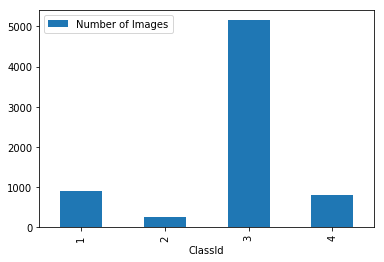

In [6]:
df_defect_count = train_df.groupby(['ClassId']).count()
df_defect_count=df_defect_count.drop('ImageId',axis=1)
df_defect_count.rename(columns={'ClassId':'Defect Type','EncodedPixels': 'Number of Images'}, inplace=True)
#df_defect_count.head()
df_defect_count.plot.bar()

In [9]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

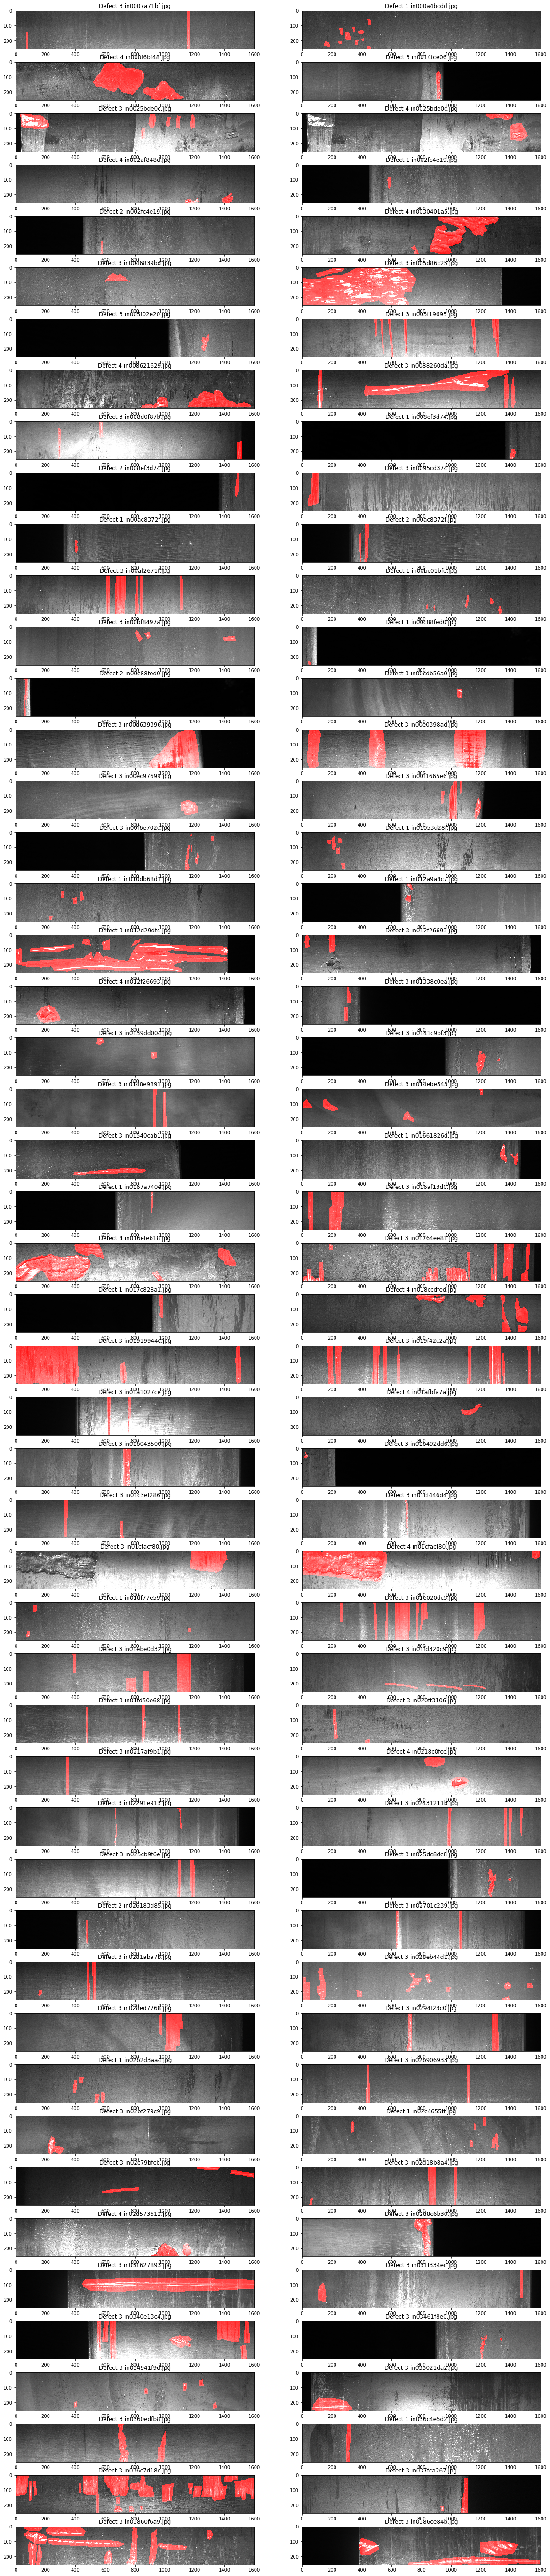

In [10]:
train_df['ImageId_ClassId']=train_df['ImageId']+"_"+(train_df['ClassId']).astype(str)

fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
for i in range(1, 100+1):
    fig.add_subplot(rows, columns, i)
    
    fn = train_df['ImageId_ClassId'].iloc[i].split('_')[0]
    cls = train_df['ImageId_ClassId'].iloc[i].split('_')[1]
    img = cv2.imread( '/home/primukh26/trainimages/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask( train_df['EncodedPixels'].iloc[i], img.shape)
    img[mask==1,0] = 255
    plt.title("Defect " + str(cls) + " in" + fn)
    plt.imshow(img)
plt.show()

In [45]:
train_c=pd.read_csv("/home/primukh26/train_im.csv")
#train_c.drop(['ClassId_1','ClassId_2','ClassId_3'], axis=1, inplace=True)
train_c.shape

(7095, 8)

In [46]:
train_c.isnull().sum()

ImageId      429
ClassId_1    429
ClassId_2      0
ClassId_3      0
Defect 1       0
Defect 2       0
Defect 3       0
Defect 4       0
dtype: int64

In [47]:
train_c = train_c.dropna()
train_c.isnull().sum()

ImageId      0
ClassId_1    0
ClassId_2    0
ClassId_3    0
Defect 1     0
Defect 2     0
Defect 3     0
Defect 4     0
dtype: int64

In [48]:
train_c.shape

(6666, 8)

In [49]:
train_c

ImageId  ClassId_1  ClassId_2  ClassId_3  Defect 1  Defect 2  \
0     0002cc93b.jpg        1.0          0          0         1         0   
1     0007a71bf.jpg        3.0          0          0         0         0   
2     000a4bcdd.jpg        1.0          0          0         1         0   
3     000f6bf48.jpg        4.0          0          0         0         0   
4     0014fce06.jpg        3.0          0          0         0         0   
...             ...        ...        ...        ...       ...       ...   
6661  ffcf72ecf.jpg        3.0          0          0         0         0   
6662  fff02e9c5.jpg        3.0          0          0         0         0   
6663  fffe98443.jpg        3.0          0          0         0         0   
6664  ffff4eaa8.jpg        3.0          0          0         0         0   
6665  ffffd67df.jpg        3.0          0          0         0         0   

      Defect 3  Defect 4  
0            0         0  
1            1         0  
2            0         0  
3            0         1  
4            1         0  
...        ...       ...  
6661         1         0  
6662         1         0  
6663         1         0  
6664         1         0  
6665         1         0  

[6666 rows x 8 columns]

In [50]:
train_c['Label']=train_c['ClassId_1'].astype(str) + "," + train_c['ClassId_2'].astype(str) + ","+train_c['ClassId_3'].astype(str)

In [51]:
train_c.drop(['ClassId_1','ClassId_2','ClassId_3'], axis=1, inplace=True)
train_c


ImageId  Defect 1  Defect 2  Defect 3  Defect 4    Label
0     0002cc93b.jpg         1         0         0         0  1.0,0,0
1     0007a71bf.jpg         0         0         1         0  3.0,0,0
2     000a4bcdd.jpg         1         0         0         0  1.0,0,0
3     000f6bf48.jpg         0         0         0         1  4.0,0,0
4     0014fce06.jpg         0         0         1         0  3.0,0,0
...             ...       ...       ...       ...       ...      ...
6661  ffcf72ecf.jpg         0         0         1         0  3.0,0,0
6662  fff02e9c5.jpg         0         0         1         0  3.0,0,0
6663  fffe98443.jpg         0         0         1         0  3.0,0,0
6664  ffff4eaa8.jpg         0         0         1         0  3.0,0,0
6665  ffffd67df.jpg         0         0         1         0  3.0,0,0

[6666 rows x 6 columns]

In [52]:
train_c['Number of Defects']= train_c.sum(axis=1)

In [118]:
train_c[train_c['Number of Defects']>1]

ImageId  Defect 1  Defect 2  Defect 3  Defect 4    Label  \
5     0025bde0c.jpg         0         0         1         1  3.0,4,0   
7     002fc4e19.jpg         1         1         0         0  1.0,2,0   
16    008ef3d74.jpg         1         1         0         0  1.0,2,0   
18    00ac8372f.jpg         1         1         0         0  1.0,2,0   
22    00c88fed0.jpg         1         1         0         0  1.0,2,0   
...             ...       ...       ...       ...       ...      ...   
5701  d98664198.jpg         0         1         1         0  2.0,3,0   
5702  d99f9f7ac.jpg         0         0         1         1  3.0,4,0   
5737  db3ce9c95.jpg         0         0         1         1  3.0,4,0   
5740  db4867ee8.jpg         1         1         1         0  1.0,2,3   
6253  ef24da2ba.jpg         1         0         1         0  1.0,0,3   

      Number of Defects  
5                     2  
7                     2  
16                    2  
18                    2  
22                    2  
...                 ...  
5701                  2  
5702                  2  
5737                  2  
5740                  3  
6253                  2  

[363 rows x 7 columns]

In [55]:
localFolder = '/home/primukh26/trainimages/'
list_f = os.listdir(localFolder)
number_files = len(list_f)
print (number_files)

12568


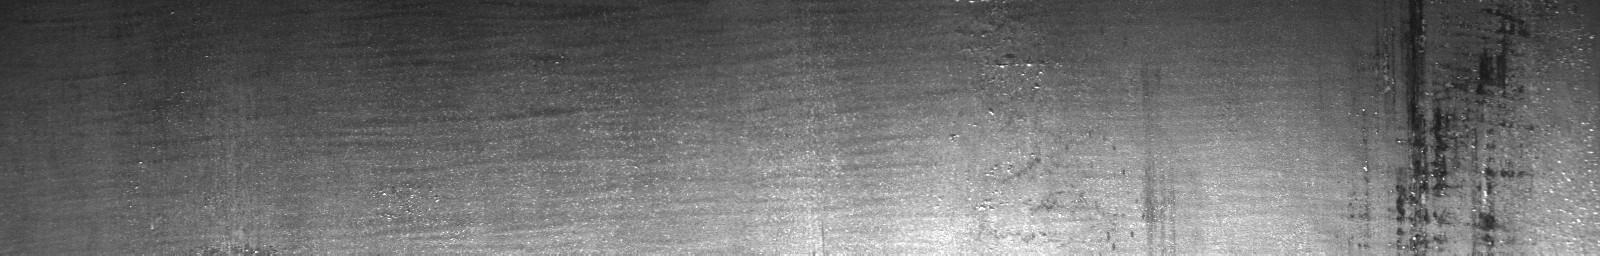

In [57]:
fileName = list_f[1]  
localpath = localFolder + fileName
image.load_img(localpath)

In [74]:
train_image = []
for i in tqdm(range(train_c.shape[0])):
    fileName = list_f[i]  
    localpath = localFolder
    img = image.load_img(localpath+train_c['ImageId'][i],target_size=(100,100,1))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 6666/6666 [00:41<00:00, 160.48it/s]


In [75]:
X.shape

(6666, 100, 100, 3)

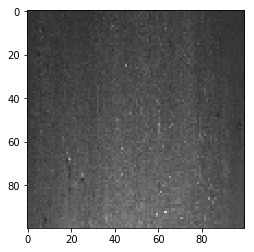

In [76]:
plt.imshow(X[2])

In [80]:
train_c['Label'][2]

'1.0,0,0'

In [81]:
y = np.array(train_c.drop(['ImageId', 'Label','Number of Defects'],axis=1))

In [82]:
y

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [84]:
model = Sequential()
#input layer
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(100,100,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#hidden layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='sigmoid'))

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 64)       

In [86]:
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [87]:
opt=keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy',auc])

In [126]:
nb_epoch = 200
nb_classes = 4
batch_size = 256
hist=model.fit(X_train, y_train,batch_size = batch_size, nb_epoch = nb_epoch, validation_data=(X_test, y_test), shuffle=True)

Train on 5999 samples, validate on 667 samples
Epoch 1/200
 256/5999 [>.............................] - ETA: 3s - loss: 0.3976 - accuracy: 0.8359 - auc: 0.9458

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


5999/5999 [==============================] - 3s 500us/step - loss: 0.4242 - accuracy: 0.8433 - auc: 0.9459 - val_loss: 0.7019 - val_accuracy: 0.7571 - val_auc: 0.9460
Epoch 2/200
5999/5999 [==============================] - 3s 480us/step - loss: 0.4230 - accuracy: 0.8405 - auc: 0.9461 - val_loss: 0.5647 - val_accuracy: 0.8156 - val_auc: 0.9462
Epoch 3/200
5999/5999 [==============================] - 3s 481us/step - loss: 0.4171 - accuracy: 0.8463 - auc: 0.9463 - val_loss: 0.6245 - val_accuracy: 0.8201 - val_auc: 0.9464
Epoch 4/200
5999/5999 [==============================] - 3s 481us/step - loss: 0.4151 - accuracy: 0.8418 - auc: 0.9465 - val_loss: 0.6441 - val_accuracy: 0.8081 - val_auc: 0.9466
Epoch 5/200
5999/5999 [==============================] - 3s 483us/step - loss: 0.4092 - accuracy: 0.8486 - auc: 0.9467 - val_loss: 0.6239 - val_accuracy: 0.8201 - val_auc: 0.9468
Epoch 6/200
5999/5999 [==============================] - 3s 484us/step - loss: 0.4239 - accuracy: 0.8426 - auc: 0.946

In [127]:
def learning_curve(history,epoch):
    #plot auc curve
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model auc')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

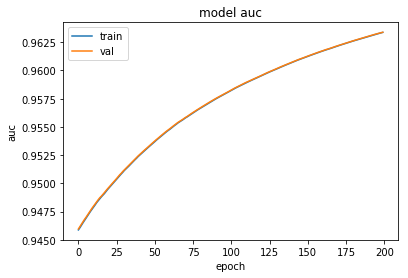

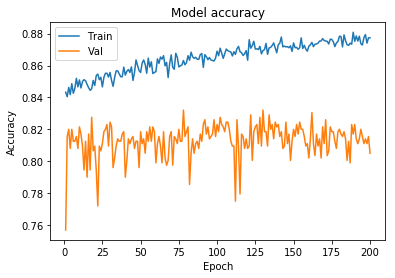

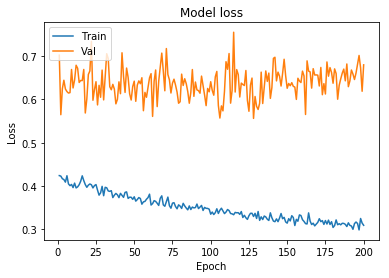

In [128]:
learning_curve(hist,200)

Enter filename to test: 00ac8372f.jpg
Defect 2 (0.596)
Defect 1 (0.553)


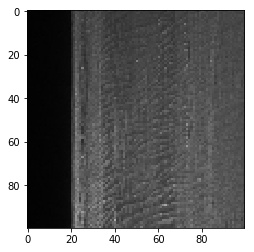

In [125]:
fileName_test = input("Enter filename to test: ")
import os
localFolder_test = '/home/primukh26/trainimages/'
localpath_test = localFolder_test + fileName_test
img = image.load_img(localpath_test,target_size=(100,100,1))
img = image.img_to_array(img)
img = img/255
#proba = model.predict(img.reshape(1,100,100,3))
classes = np.array(train_c.columns[1:5])
proba = model.predict(img.reshape(1,100,100,3))
#top = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    if proba[0][top[i]]>0.5:
        print("{}".format(classes[top[i]])+" ({:.3})".format(proba[0][top[i]]))
plt.imshow(img)